In [2]:
#Imports
from osgeo import gdal, osr
import rasterio
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import re

# Preprocess images
Only needs to be executed when new images are put into data

In [3]:
def convert_rcp(filepath: str) -> dict:
    # Regular expression pattern to extract the RPC values
    pattern = r'(-?\d+(?:\.\d+)?)'

    # Read the RPC values from the text file
    with open(filepath, 'r') as file:
        rpc_values = file.read()

    # Extract the RPC values using the regular expression
    values = [str(x) for x in re.findall(pattern, rpc_values)]

    # Create a dictionary with the keys and values
    rpc_dict = {
        'LINE_OFF': values[0],
        'SAMP_OFF': values[1],
        'LAT_OFF': values[2],
        'LONG_OFF': values[3],
        'HEIGHT_OFF': values[4],
        'LINE_SCALE': values[5],
        'SAMP_SCALE': values[6],
        'LAT_SCALE': values[7],
        'LONG_SCALE': values[8],
        'HEIGHT_SCALE': values[9],
        'LINE_NUM_COEFF': ' '.join(values[10:30]),
        'LINE_DEN_COEFF': ' '.join(values[30:50]),
        'SAMP_NUM_COEFF': ' '.join(values[50:70]),
        'SAMP_DEN_COEFF': ' '.join(values[70:90]),
    	'MIN_LONG': values[91],
        'MIN_LAT': values[92],
        'MAX_LONG': values[93],
        'MAX_LAT': values[94],
        'sampleOFFSET': values[95],
        #'lineOFFSET': values[96],
    }
    return rpc_dict

In [4]:
def write_rpc_into_geotiff(image_ds_name, rpc_name) -> None:
    image_ds = gdal.Open(image_ds_name)
    rpc = convert_rcp(rpc_name)

    driver = gdal.GetDriverByName('GTiff')
    georef_ds = driver.Create(image_ds_name, image_ds.RasterXSize, image_ds.RasterYSize, image_ds.RasterCount, gdal.GDT_Byte)
    georef_ds.SetMetadata(rpc, 'RPC')
    georef_ds.GetRasterBand(1).WriteArray(image_ds.GetRasterBand(1).ReadAsArray())
    image_ds = None
    georef_ds = None

In [5]:
#get list of tif files in data folder

tif_list = []
rpc_list = []
for file in os.listdir("data"):
    if file.endswith(".tif"):
        tif_list.append(file)
        rpc_list.append(f"rpc_{file[:-4]}.txt")

for image, rpc in zip(tif_list, rpc_list):
    rpc_dict = convert_rcp(f"data/{rpc}")
    write_rpc_into_geotiff(f"data/{image}", f"data/{rpc}")
    #move image to processed folder
    os.rename(f"data/{image}", f"preprocessed/{image}")
    os.remove(f"data/{rpc}")


## Functions

In [6]:
#CANT use this due to missing stereo_calibration_matrix
def generate_dem(cv_image1, cv_image2, output:str):
    # Set up the stereo block matching algorithm
    bm = cv2.StereoBM_create()

    # Compute the disparity map
    disparity = bm.compute(cv_image1, cv_image2)

    # Convert the disparity map to a 3D point cloud
    points_3d = cv2.reprojectImageTo3D(disparity, stereo_calibration_matrix)

    # Save the point cloud to a file
    np.save(output, points_3d)

In [7]:
def warp_image(image_ds, output):
    # Create a georeferenced version of the image using the RPCs
    driver = gdal.GetDriverByName('GTiff')
    georef_ds = driver.Create(f'{PATH_TO_TEMP}georef.tif', image_ds.RasterXSize, image_ds.RasterYSize, image_ds.RasterCount, gdal.GDT_Byte)
    georef_ds.SetMetadata(image_ds.GetMetadata('RPC'), 'RPC')
    georef_ds.GetRasterBand(1).WriteArray(image_ds.GetRasterBand(1).ReadAsArray())
    #print(georef_ds.GetMetadata('RPC'))
    image_ds = None
    georef_ds = None

    # Reproject the images to the same projection (EPSG:3857 in this case)
    # EPSG:4326, EPSG:7789 also not working
    gdal.Warp(output, f'{PATH_TO_TEMP}georef.tif')
    os.remove(f'{PATH_TO_TEMP}georef.tif')

In [8]:
def stitch_images(cv_image1, cv_image2, outputpath:str):
    # Create the stitcher object
    stitcher = cv2.Stitcher.create()

    # Stitch the images together
    status, stitched_image = stitcher.stitch((cv_image1, cv_image2))

    # Check if the stitching was successful
    if status == cv2.Stitcher_OK:
        # Save the stitched image
        cv2.imwrite(outputpath, stitched_image)
        return stitched_image
    else:
        print(f'Stitching failed! with error {status}')
        return -1
    

In [9]:
def get_disparity_map(cv_image1, cv_image2, roi:list=None) -> np.ndarray:    
    if cv_image1.shape != cv_image2.shape:
        #pad the smaller image
        if cv_image1.shape[0] < cv_image2.shape[0]:
            cv_image1 = np.pad(cv_image1, ((0, cv_image2.shape[0]-cv_image1.shape[0]), (0, 0), (0, 0)), 'constant')
        else:
            cv_image2 = np.pad(cv_image2, ((0, cv_image1.shape[0]-cv_image2.shape[0]), (0, 0), (0, 0)), 'constant')
        if cv_image1.shape[1] < cv_image2.shape[1]:
            cv_image1 = np.pad(cv_image1, ((0, 0), (0, cv_image2.shape[1]-cv_image1.shape[1]), (0, 0)), 'constant')
        else:
            cv_image2 = np.pad(cv_image2, ((0, 0), (0, cv_image1.shape[1]-cv_image2.shape[1]), (0, 0)), 'constant')
            
    if roi is not None:
        # Crop the images to the same size
        cv_image1 = cv_image1[roi[0]:roi[1], roi[2]:roi[3]]
        cv_image2 = cv_image2[roi[0]:roi[1], roi[2]:roi[3]]

    # Convert the images to grayscale
    gray_1 = cv2.cvtColor(cv_image1, cv2.COLOR_BGR2GRAY)
    gray_2 = cv2.cvtColor(cv_image2, cv2.COLOR_BGR2GRAY)



    # Set up the block matching algorithm
    bm = cv2.StereoBM_create()

    #print(image_1.shape, image_2.shape)

    # Compute the disparity map
    return bm.compute(gray_1, gray_2)

In [10]:
def plot_3d_reconstruction(disparity:np.ndarray, rpc_1:dict, rpc_2:dict) -> None:    
    #TODO: probably use this fuction part for depth
    focal_length = 13.5*(10**(-3)) # Focal length in meters found by chatGPT

    # Compute the baseline using the RPCs
    baseline = np.abs(float(rpc_1['LINE_OFF']) - float(rpc_2['LINE_OFF']))
    depth = focal_length * baseline / disparity

    x, y = np.meshgrid(np.arange(3001),np.arange(3001))
    # Create a figure and a 3D Axes
    fig = plt.figure(figsize=(8,4.5))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the points
    ax.scatter(x, y, depth)

    # Show the plot
    plt.show()

In [11]:
def crop_images(image1_path:str, image2_path:str):

    # Open the first image
    ds1 = gdal.Open(image1_path)

    # Read the georeferencing information
    geotransform = ds1.GetGeoTransform()
    srs = osr.SpatialReference()
    srs.ImportFromWkt(ds1.GetProjection())

    # Get the size of the image in pixels
    x_size, y_size = ds1.GetRasterBand(1).GetBlockSize()

    # Calculate the extent of the image in the original projection
    min_x = abs(geotransform[0])
    max_x = abs(geotransform[0]) + abs(x_size * geotransform[1])
    min_y = abs(geotransform[3]) + abs(y_size * geotransform[5])
    max_y = abs(geotransform[3])
    extent_1 = (min_x, max_x, min_y, max_y)

    # Open the second image
    ds2 = gdal.Open(image2_path)

    # Read the georeferencing information
    geotransform = ds2.GetGeoTransform()
    srs = osr.SpatialReference()
    srs.ImportFromWkt(ds2.GetProjection())

    # Get the size of the image in pixels
    x_size, y_size = ds2.GetRasterBand(1).GetBlockSize()

    # Calculate the extent of the image in the original projection
    min_x = abs(geotransform[0])
    max_x = abs(geotransform[0]) + abs(x_size * geotransform[1])
    min_y = abs(geotransform[3]) + abs(y_size * geotransform[5])
    max_y = abs(geotransform[3])
    extent_2 = (min_x, max_x, min_y, max_y)

    # Calculate the intersection of the two extents
    min_x = max(extent_1[0], extent_2[0])
    max_x = min(extent_1[1], extent_2[1])
    min_y = max(extent_1[2], extent_2[2])
    max_y = min(extent_1[3], extent_2[3])

    # Crop the images to the intersection extent
    ds1_cropped = gdal.Translate('image_1_cropped.tif', ds1, projWin=[min_x, max_y, max_x, min_y])
    ds2_cropped = gdal.Translate('image_2_cropped.tif', ds2, projWin=[min_x, max_y, max_x, min_y])
    return ds1_cropped, ds2_cropped

In [12]:
def calculate_3d_points (disparity:np.ndarray,ds_georef,scale:int) -> np.ndarray:
    
    num_rows, num_cols = disparity.shape

    points_3d = np.empty((num_rows, num_cols, 3))
    for i in range(num_rows):
        for j in range(num_cols):
            points_3d[i,j,0] = ds_georef.GetGeoTransform()[0] + j*ds_georef.GetGeoTransform()[1] + i*ds_georef.GetGeoTransform()[2]
            points_3d[i,j,1] = ds_georef.GetGeoTransform()[3] + j*ds_georef.GetGeoTransform()[4] + i*ds_georef.GetGeoTransform()[5]
            points_3d[i,j,2] = disparity[i,j]/scale
    return points_3d

In [13]:
def plot_3d(points,scale:int):
    # Extract the x, y, and z coordinates of the points
    x = points[:, :, 0]
    y = points[:, :, 1]
    z = points[:, :, 2]

    # Create a figure and a 3D Axes
    fig = plt.figure(figsize=(8,4.5))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the points
    #max z axis value is z.max()*scale
    ax.set_zlim(0, z.max()*scale)
    ax.scatter(x[::2], y[::2], z[::2],linewidths=0.1, alpha=0.5, s=0.1,cmap='viridis')

    # Show the plot
    plt.show()

In [14]:
def plot_3d_filtered(points,scale:int):
    # Extract the x, y, and z coordinates of the points
    x = points[:, :, 0]
    y = points[:, :, 1]
    z = points[:, :, 2]

    # Create a figure and a 3D Axes
    fig = plt.figure(figsize=(8,4.5))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the points
    ax.set_zlim(0, z.max()*scale)
    ax.scatter(x[z>=1], y[z>=1], z[z>=1],linewidths=0.1, alpha=0.5, s=1)

    # Show the plot
    plt.show()

In [15]:
def allign_coords(image_coords1, image_coords2):
    from scipy.optimize import minimize
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Assume we have two sets of 3D image coordinates, called 'image_coords1' and 'image_coords2'
    
    # Define an objective function that calculates the alignment error
    def alignment_error(params, points1, points2):
        rotation_matrix = np.array([
            [np.cos(params[2]), -np.sin(params[2]), 0],
            [np.sin(params[2]), np.cos(params[2]), 0],
            [0, 0, 1]
        ])
        translation_vector = np.array([params[0], params[1], 0])
        transformed_points = np.dot(points2, rotation_matrix.T) + translation_vector
        return np.sum((points1 - transformed_points) ** 2)
    
    # Initialize the optimization
    x0 = [0, 0, 0]
    result = minimize(alignment_error, x0, args=(image_coords1, image_coords2))
    params = result.x
    
    # Apply the optimal transformation to the second point cloud
    rotation_matrix = np.array([
        [np.cos(params[2]), -np.sin(params[2]), 0],
        [np.sin(params[2]), np.cos(params[2]), 0],
        [0, 0, 1]
    ])
    translation_vector = np.array([params[0], params[1], 0])
    image_coords2_aligned = np.dot(image_coords2, rotation_matrix.T) + translation_vector
    
    # Remove outliers by ignoring points with large distances
    distances = np.sum((image_coords1 - image_coords2_aligned) ** 2, axis=1,keepdims=True)
    outlier_mask = distances < np.percentile(distances, 90) # keep 98% of the data
    print(outlier_mask[:,0,:].shape)
    #TODO: FILTER OUTLIER
    image_coords1_filtered = image_coords1
    image_coords2_aligned_filtered = image_coords2_aligned
    
    # Plot the aligned point cloud, ignoring the outliers
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(image_coords1_filtered[:, 0], image_coords1_filtered[:, 1], image_coords1_filtered[:, 2], c='r', marker='o')
    ax.scatter(image_coords2_aligned_filtered[:, 0], image_coords2_aligned_filtered[:, 1], image_coords2_aligned_filtered[:, 2], c='b', marker='o')
    ax.set_xlim3d(0, 20000)
    ax.set_ylim3d(0, 20000)
    plt.show()

In [16]:
def get_min_max_long_lat_of_image(image_path):
    # Assume we have a set of 3D image coordinates, called 'image_coords'
    # Define a function that converts 3D image coordinates to longitudes and latitudes
    ds = gdal.Open(image_path)
    width = ds.RasterXSize
    height = ds.RasterYSize
    gt = ds.GetGeoTransform()
    print(gt)
    minx = gt[0]
    miny = gt[3] + width*gt[4] + height*gt[5] 
    maxx = gt[0] + width*gt[1] + height*gt[2]
    maxy = gt[3] 
    return minx, maxx, miny, maxy

## Main Function

In [17]:
#Global Variables
#Path to the folder containing the images
PATH_TO_IMAGES = 'preprocessed/'
PATH_TO_TEMP = 'temp/'
IMAGES = [file for file in os.listdir(PATH_TO_IMAGES) if file.endswith('.tif')]
REPROJECTED_IMAGES = [f'reprojected_{file}' for file in IMAGES]

In [18]:
#MAIN

# Open the images as datasets
image_1_ds = gdal.Open(f'{PATH_TO_IMAGES}{IMAGES[4]}')
image_2_ds = gdal.Open(f'{PATH_TO_IMAGES}{IMAGES[5]}')

In [19]:
#function to downscale geotiff
def downscale_geotiff(image_ds, scale, output_path):
    # Get the image size
    width = image_ds.RasterXSize
    height = image_ds.RasterYSize

    # Get the image geotransform
    gt = image_ds.GetGeoTransform()

    # Create a new geotransform for the downsampled image
    new_gt = list(gt)
    new_gt[1] = gt[1] * scale
    new_gt[5] = gt[5] * scale

    # Create a new raster dataset for the downsampled image
    driver = gdal.GetDriverByName('GTiff')
    new_ds = driver.Create(f'{PATH_TO_TEMP}{output_path}', int(width / scale), int(height / scale), 1, gdal.GDT_Float32)
    new_ds.SetGeoTransform(new_gt)

    # Perform the downsampling
    gdal.ReprojectImage(image_ds, new_ds, None, None, gdal.GRA_Bilinear)

    

    # Close the datasets
    new_ds = None
    image_ds = None

In [20]:
# Warp images to ground coordinates
for i in range(len(IMAGES)):
    warp_image(gdal.Open(f'{PATH_TO_IMAGES}{IMAGES[i]}'),f'{PATH_TO_TEMP}{REPROJECTED_IMAGES[i]}')

In [21]:

#warp_image(image_1_ds,f'{PATH_TO_TEMP}{REPROJECTED_IMAGES[1]}')
#warp_image(image_2_ds,f'{PATH_TO_TEMP}{REPROJECTED_IMAGES[0]}')

# Downscale images
#DOWNSCALED_IMAGES = ['image1_downscaled.tif', 'image2_downscaled.tif']
#downscale_geotiff(gdal.Open(f'{PATH_TO_TEMP}{REPROJECTED_IMAGES[0]}'), 4, DOWNSCALED_IMAGES[0])
#downscale_geotiff(gdal.Open(f'{PATH_TO_TEMP}{REPROJECTED_IMAGES[1]}'), 4, DOWNSCALED_IMAGES[1])
# create disparity map out of 2 geo-referenced images

#image_1 = cv2.imread(f'{PATH_TO_TEMP}{REPROJECTED_IMAGES[0]}')
#image_2 = cv2.imread(f'{PATH_TO_TEMP}{REPROJECTED_IMAGES[1]}')
#disparity = get_disparity_map(image_1, image_2)
#import time
#start = time.time()
#image_1 = cv2.imread(f'{PATH_TO_TEMP}{REPROJECTED_IMAGES[0]}')
#image_2 = cv2.imread(f'{PATH_TO_TEMP}{REPROJECTED_IMAGES[1]}')
#disparity = get_disparity_map(image_1, image_2)
#print(time.time()-start)

pairs = [[0, 1],[0, 25],[2, 8],[2, 13],[3, 6],[4, 49],[6, 13],[8, 32]]
list_of_disparities = []
for i,j in pairs:
    image_1 = cv2.imread(f'{PATH_TO_TEMP}{REPROJECTED_IMAGES[i]}')
    image_2 = cv2.imread(f'{PATH_TO_TEMP}{REPROJECTED_IMAGES[j]}')
    disparity = get_disparity_map(image_1, image_2)
    print(f'{i} {j+i+1}')
    list_of_disparities.append(disparity)

0 2
0 26
2 11
2 16
3 10
4 54
6 20
8 41


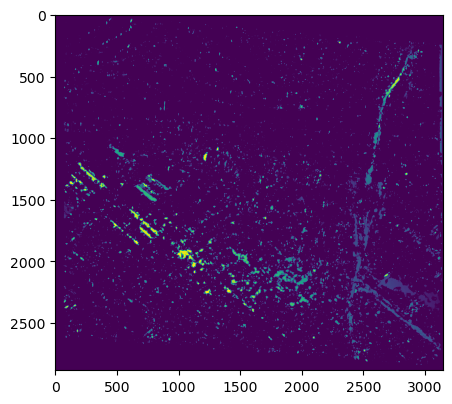

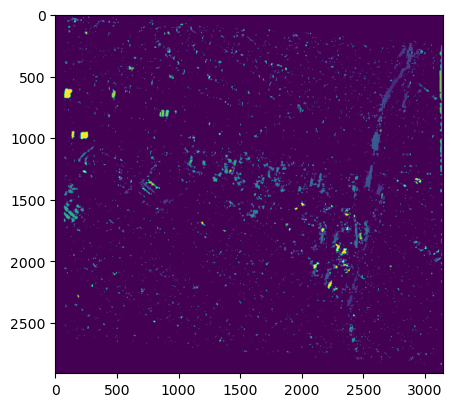

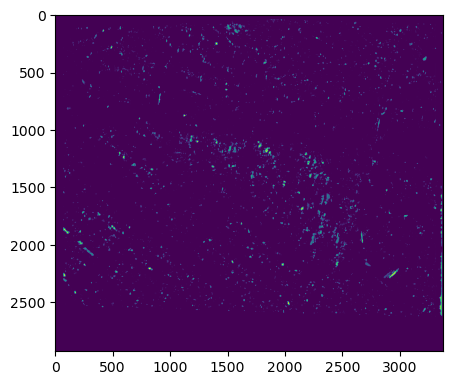

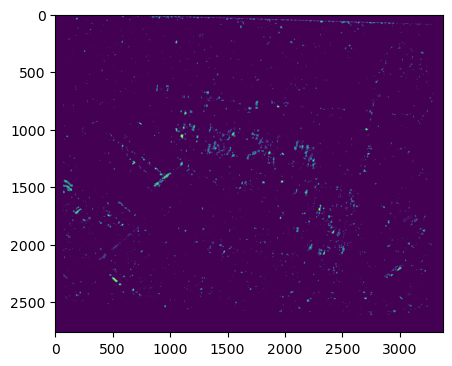

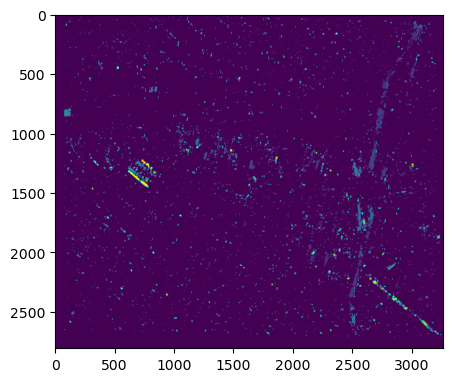

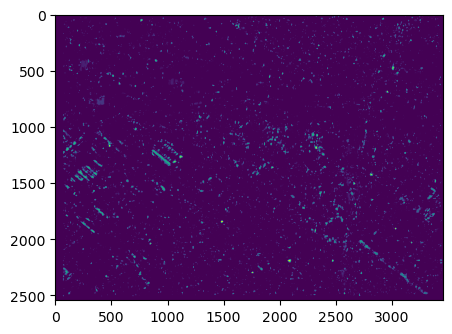

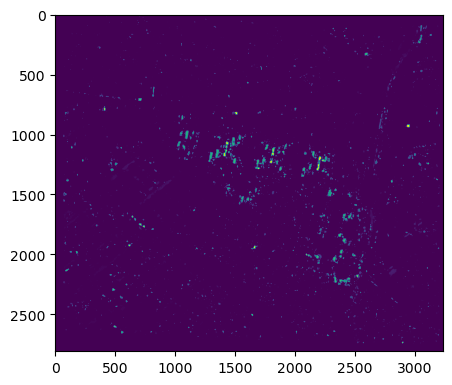

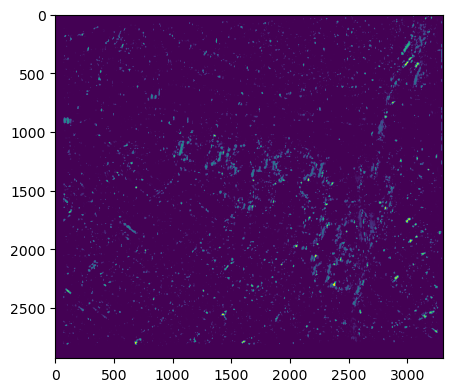

In [24]:
#plot all disparities

for i in range(1):
    for j in range(len(list_of_disparities)):
        fig = plt.figure(figsize=(5, 5))
        plt.imshow(list_of_disparities[j])
        plt.show()



In [42]:
points = []
for i,disparity in enumerate(list_of_disparities):
    warp_image = gdal.Open(f'{PATH_TO_TEMP}{REPROJECTED_IMAGES[pairs[i][0]]}')
    points.append(calculate_3d_points(disparity, warp_image,scale=60))



In [71]:
#min,max long lat of all images
min_long = 0
max_long = -90
min_lat = 0
max_lat = -90
for image in points:
    top_left = image[0][0]
    bottom_right = image[-1][-1]
    if top_left[0] > max_long:
        max_long = top_left[0]
    if top_left[1] < min_lat:
        min_lat = top_left[1]
    if bottom_right[0] < min_long:
        min_long = bottom_right[0]
    if bottom_right[1] > max_lat:
        max_lat = bottom_right[1]
print(min_long, max_long, min_lat, max_lat)

-58.533294726966545 -58.528779867879464 -34.54905545628181 -34.53811103109612


In [87]:
def find_corners(image):
    idx_top = 0
    idx_left = 0
    idx_right = 0
    idx_bottom = 0
    for i in range(len(image[0])):
        if(image[0][i][0] <= min_long):
            #print(image[0][i][0])
            idx_left = i        
        if(image[0][-i][0] >= max_long):
            #print(image[0][-i][0])
            idx_right = len(image[0])-i
        if(image[0][idx_left][0] <= min_long and image[0][idx_right][0] >= max_long):
            break
    
    for i in range(len(image)):
        if(image[i][0][1] <= max_lat):
            idx_top = i
        if(image[-i][0][1] >= min_lat):
            idx_bottom = len(image)-i
        if(image[idx_top][0][1] <= max_lat and image[idx_bottom][0][1] >= min_lat):
            break
    print(idx_top, idx_left, idx_right, idx_bottom)    
    return idx_top, idx_left, idx_right, idx_bottom
cropped = []
for image in points:
    #print(image.shape)
    top,left,right,bottom = find_corners(image)
    image= image[top:bottom,left:right,:]
    cropped.append(image)
    #image.crop((left, top, right, bottom))
    print(image.shape)

1763 1 3143 1121
(0, 3142, 3)
1763 1 3143 1145
(0, 3142, 3)
1183 0 1068 1745
(562, 1068, 3)
1183 0 1068 1582
(399, 1068, 3)


IndexError: index 2808 is out of bounds for axis 0 with size 2808

In [93]:
flattened = np.array(points[0]).reshape(-1,3)
for i in range(1,len(points)):
    flattened = np.concatenate((flattened,np.array(points[i]).reshape(-1,3)),axis=0)
print(flattened.shape)

(74109863, 3)


In [ ]:
coords = points[:,:,0:2].reshape(-1,2)
height = points[:,:,2].reshape(-1,1)


(2884, 3144, 3)


In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
# Plot the points
for i in range(len(points)-2):
    x = points[i][:,:,0]
    y = points[i][:,:,1]
    z = points[i][:,:,2]/100

    #limit plot height in inches
    ax.set_box_aspect((5,5,z.max()-z.min()))
    ax.plot_surface(X=x,Y=y,Z=z,cmap='viridis',edgecolor='none')

# remove labels and raster
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_zticks([])

plt.show()


In [ ]:
image_1_reprojected = gdal.Open(f'{PATH_TO_TEMP}{REPROJECTED_IMAGES[0]}')
print(image_1_reprojected.GetGeoTransform())

# point cloud from disparity map and georeferenced images

(-58.535951209296485, 3.7652093925175356e-06, 0.0, -34.53147524791334, 0.0, -3.7652093925175356e-06)


In [ ]:
#construct 3D point cloud from disparity map
image_1_coords = get_3d_coords(disparity, image_1, rpc_1)
image_2_coords = get_3d_coords(disparity, image_2, rpc_2)

NameError: name 'get_3d_coords' is not defined

In [ ]:
# Stitch images
stitched_image = stitch_images(image_1,image_2,f'{PATH_TO_TEMP}stitched_image.tif')
if stitched_image != -1:
    # Plot the stitched image
    plt.imshow(stitched_image)
    plt.show()


Stitching failed! with error 1


In [ ]:
# Clear tmp folder
for file in os.listdir(PATH_TO_TEMP):
    os.remove(f'{PATH_TO_TEMP}{file}')

In [ ]:
#3D reconstruction
#TODO: Check why division by zero error in disparity
print(get_min_max_long_lat_of_image('temp/image2_reprojected.tif'))
#plot_3d_reconstruction(disparity, rpc_1, rpc_2)
#points_left, points_right = calculate_3d_points(disparity, rpc_1, rpc_2)
#plot_3d(points_left)
#plot_3d(points_right)

(-58.48579997758683, 3.834783330242905e-06, 0.0, -34.485245113773985, 0.0, -3.834783330242905e-06)
(-58.48579997758683, -58.47232071418102, -34.49562203746562, -34.485245113773985)


In [ ]:
# get the longitude and latitude out of RPCs



(3001, 3)


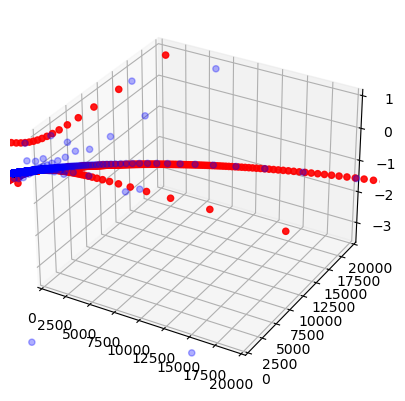

In [ ]:
allign_coords(points_left, points_right)

In [ ]:
# triangulate using image1 and image2


In [ ]:
#TODO: CHECK IF WE STILL NEED DIS?
# Estimate the relative depths of the pixels using the RPCs
image_1_ds = gdal.Open('img_01.tif')
image_2_ds = gdal.Open('img_02.tif')

rpc_1 = image_1_ds.GetMetadata('RPC')
rpc_2 = image_2_ds.GetMetadata('RPC')
#rpc_1 = convert_rcp('/root/PLUS-IBBC/rpc_05.txt')
#rpc_2 = convert_rcp('/root/PLUS-IBBC/rpc_06.txt')



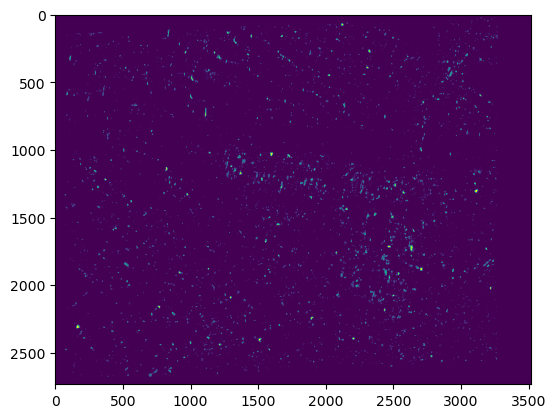

## HELP STUFF:
This stuff is to figure out what actually is in an image, and to modify the images

In [ ]:
# Open the image
image_ds = gdal.Open('temp/image2_reprojected.tif')
#image_test = gdal.Open('01.tif')

# Get the RPCs for the image
rpc = image_ds.GetMetadata('RPC')
print(image_ds.GetMetadataDomainList())
#print(image_test.GetMetadataDomainList())
print(image_ds.GetMetadata('DERIVED_SUBDATASETS'))
#print(image_test.GetMetadata('RPC'))

['IMAGE_STRUCTURE', 'DERIVED_SUBDATASETS', '']
{'DERIVED_SUBDATASET_1_NAME': 'DERIVED_SUBDATASET:LOGAMPLITUDE:temp/image2_reprojected.tif', 'DERIVED_SUBDATASET_1_DESC': 'log10 of amplitude of input bands from temp/image2_reprojected.tif'}


In [ ]:
# Write RPCs into image
images = ['testimgs/07.tif']
rpcs = ['testimgs/rpc_07.txt']

for image_ds_name, rpc_name in zip(images, rpcs):
    write_rpc_into_geotiff(image_ds_name, rpc_name)